In [1]:
from skimage import io as skio
path = 'img/pict.jpg'
img = skio.imread(path)

In [2]:
print("Shape of image", img.shape)
print("Dtype of image", img.dtype)

Shape of image (2891, 2498, 3)
Dtype of image uint8


From the picture we know that the picture is not gray yet, and the size is big for processing, let's resize it first

In [3]:
from PIL import Image

image = Image.open(path)
img_gray = image.convert('L')
img_gray.save("img/pict_gray.jpg")

In [4]:
new_path = "img/pict_gray.jpg"
img = skio.imread(new_path)

In [5]:
print("Shape of image", img.shape)
print("Dtype of image", img.dtype)

Shape of image (2891, 2498)
Dtype of image uint8


Let's change the size of image

In [6]:
base_height = 720

img = Image.open('img/pict_gray.jpg')
hpercent =  (base_height / float(int(img.size[1])))
wsize = int((float(img.size[0]) * float(hpercent)))
img = img.resize((wsize, base_height), Image.ANTIALIAS)
img.save("img/pict_resize.jpg")

In [7]:
new_path_resized = "img/pict_resize.jpg"
img = skio.imread(new_path_resized)

In [8]:
print("Shape of image", img.shape)
print("Dtype of image", img.dtype)

Shape of image (720, 622)
Dtype of image uint8


Following [this](https://flothesof.github.io/removing-background-scikit-image.html) our next step are:

1. Detect edges
2. Seed the obtained image to separate background from foreground
3. Perform a watershed transformation

## Detect the Edges

For detecting edges, we are using sobel filter

In [9]:
from skimage import filters
sobel = filters.sobel(img)

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200

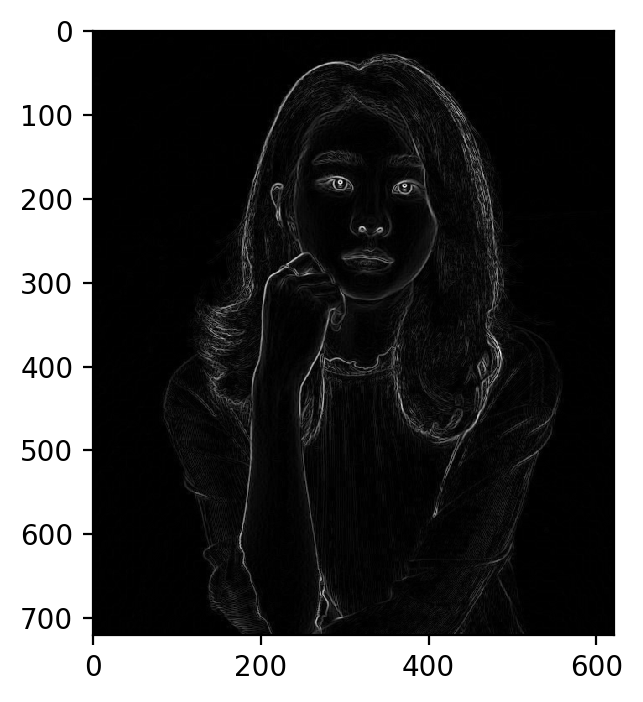

In [11]:
plt.imshow(sobel)

Let's make blur to the image, so the edges thicker

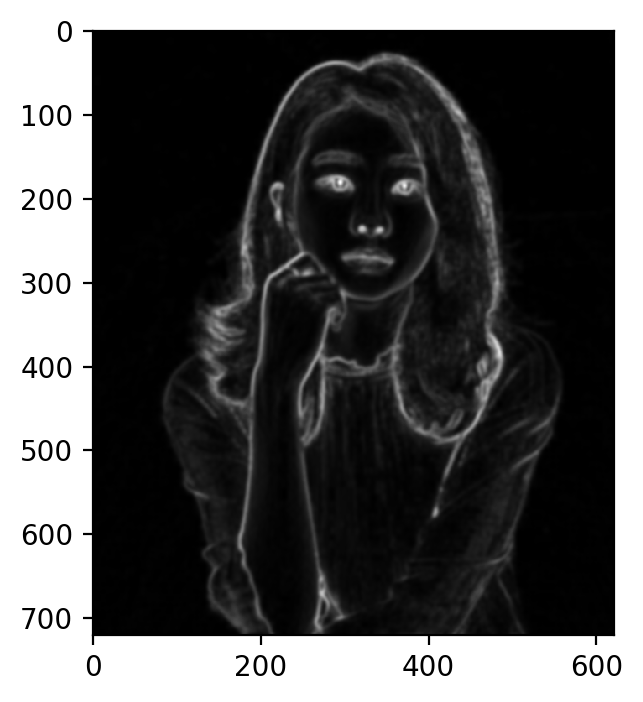

In [12]:
blurred = filters.gaussian(sobel, sigma=2.0)
plt.imshow(blurred)

## Obtaining seeds for the watershed transform

To perform watershed we need to assign classes to the fore and background,

We will do the light and dark spot from the image to obtain watershed

In [13]:
import numpy as np
light_spots = np.array((img > 245).nonzero()).T

Text(0.5, 1.0, 'Light spots of the image')

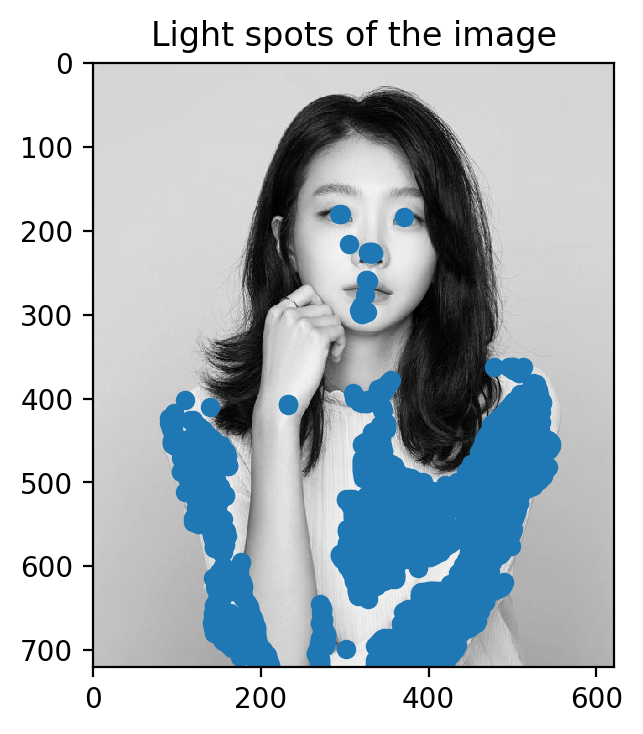

In [14]:
plt.plot(light_spots[:, -1], light_spots[:, 0], 'o')
plt.imshow(img)
plt.title("Light spots of the image")

Dark Zone

In [15]:
dark_spots = np.array((img < 3).nonzero()).T

In [16]:
dark_spots.shape

(929, 2)

Text(0.5, 1.0, 'Dark spots of the image')

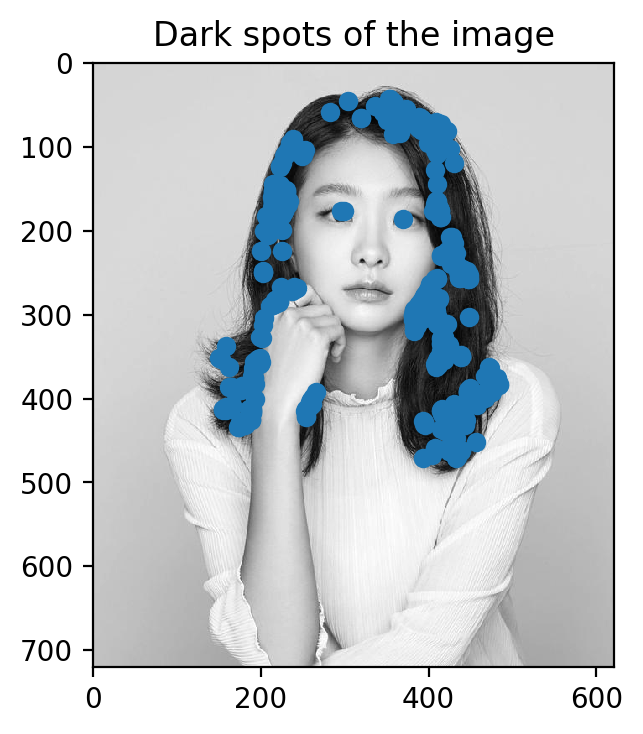

In [17]:
plt.plot(dark_spots[:, -1], dark_spots[:, 0], 'o')
plt.imshow(img)
plt.title("Dark spots of the image")

## Masking a seed mask

In [18]:
from scipy import ndimage as ndi
bool_mask = np.zeros(img.shape, dtype=np.bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndi.label(bool_mask)
num_seeds

<ipython-input-18-df72fe787fad>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool_mask = np.zeros(img.shape, dtype=np.bool)


1859

## Applying the watershed

C:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


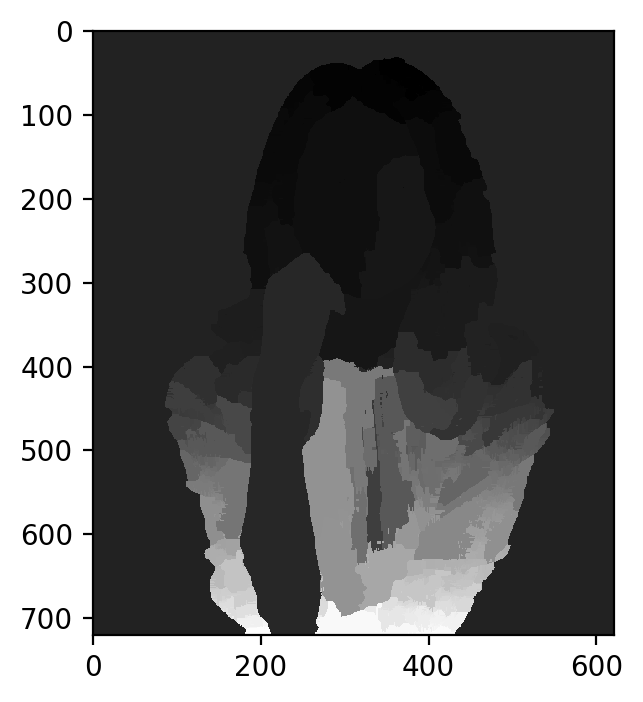

In [19]:
from skimage import morphology
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

In [20]:
background = max(set(ws.ravel()), key=lambda g: np.sum(ws == g))
background

248

In [21]:
background_mask = (ws==background)

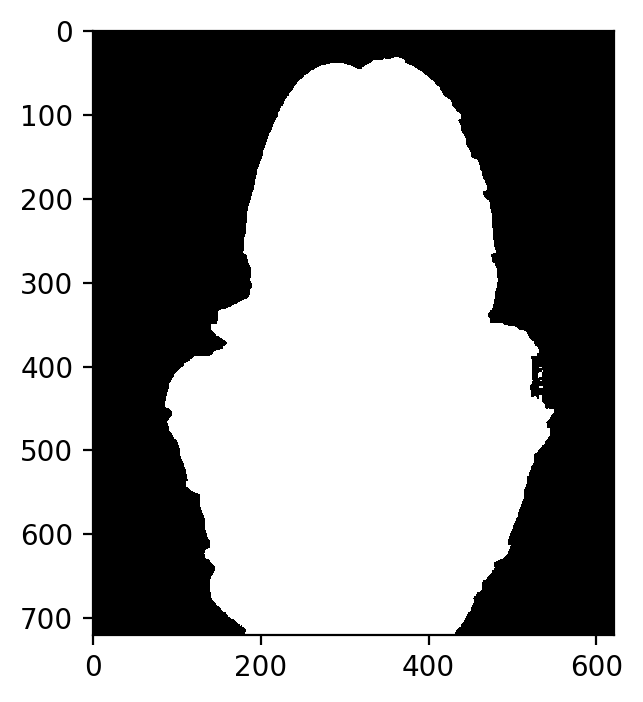

In [22]:
plt.imshow(~background_mask)

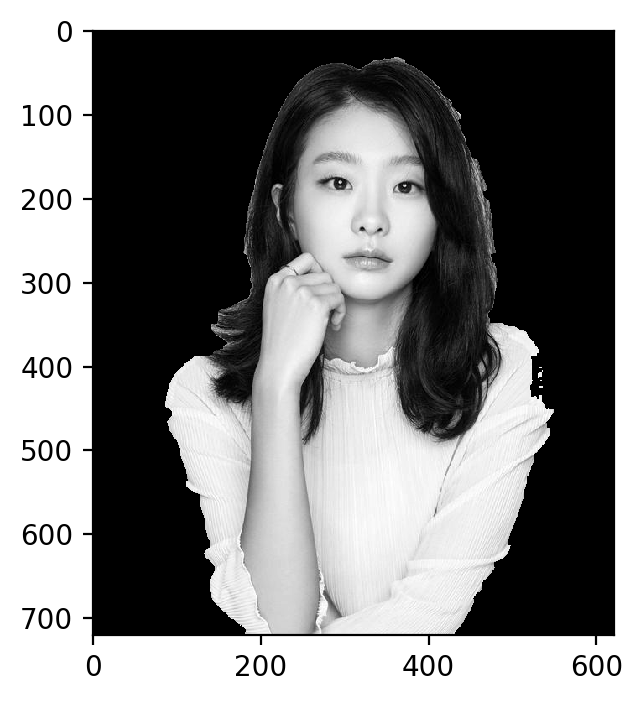

In [23]:
cleaned = img * ~background_mask
plt.imshow(cleaned)

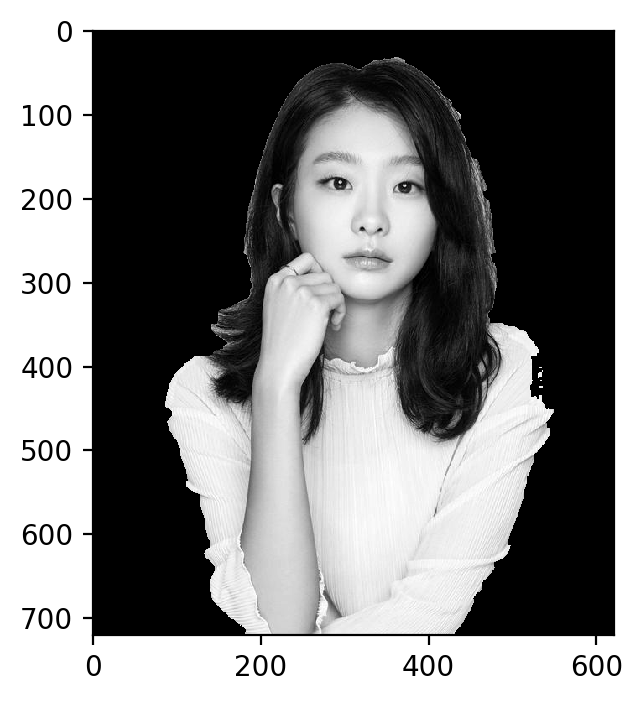

In [24]:
plt.imshow(cleaned, cmap='gray')
plt.imshow(background_mask.reshape(background_mask.shape + (1,)) * np.array([128, 255, 255, 1]))

## Picking another group

In [25]:
def draw_group_as_bg(ax, group, watershed_result, original_image):
    "Create red background"
    background_mask = (watershed_result == group)
    cleaned = original_image * ~background_mask
    ax.imshow(cleaned, cmap='gray')
    ax.imshow(background_mask.reshape(background_mask.shape + (1,)) * np.array([1, 0, 0, 1]))

In [26]:
background_candidates = sorted(set(ws.ravel()), key=lambda g: np.sum(ws==g), reverse=True)

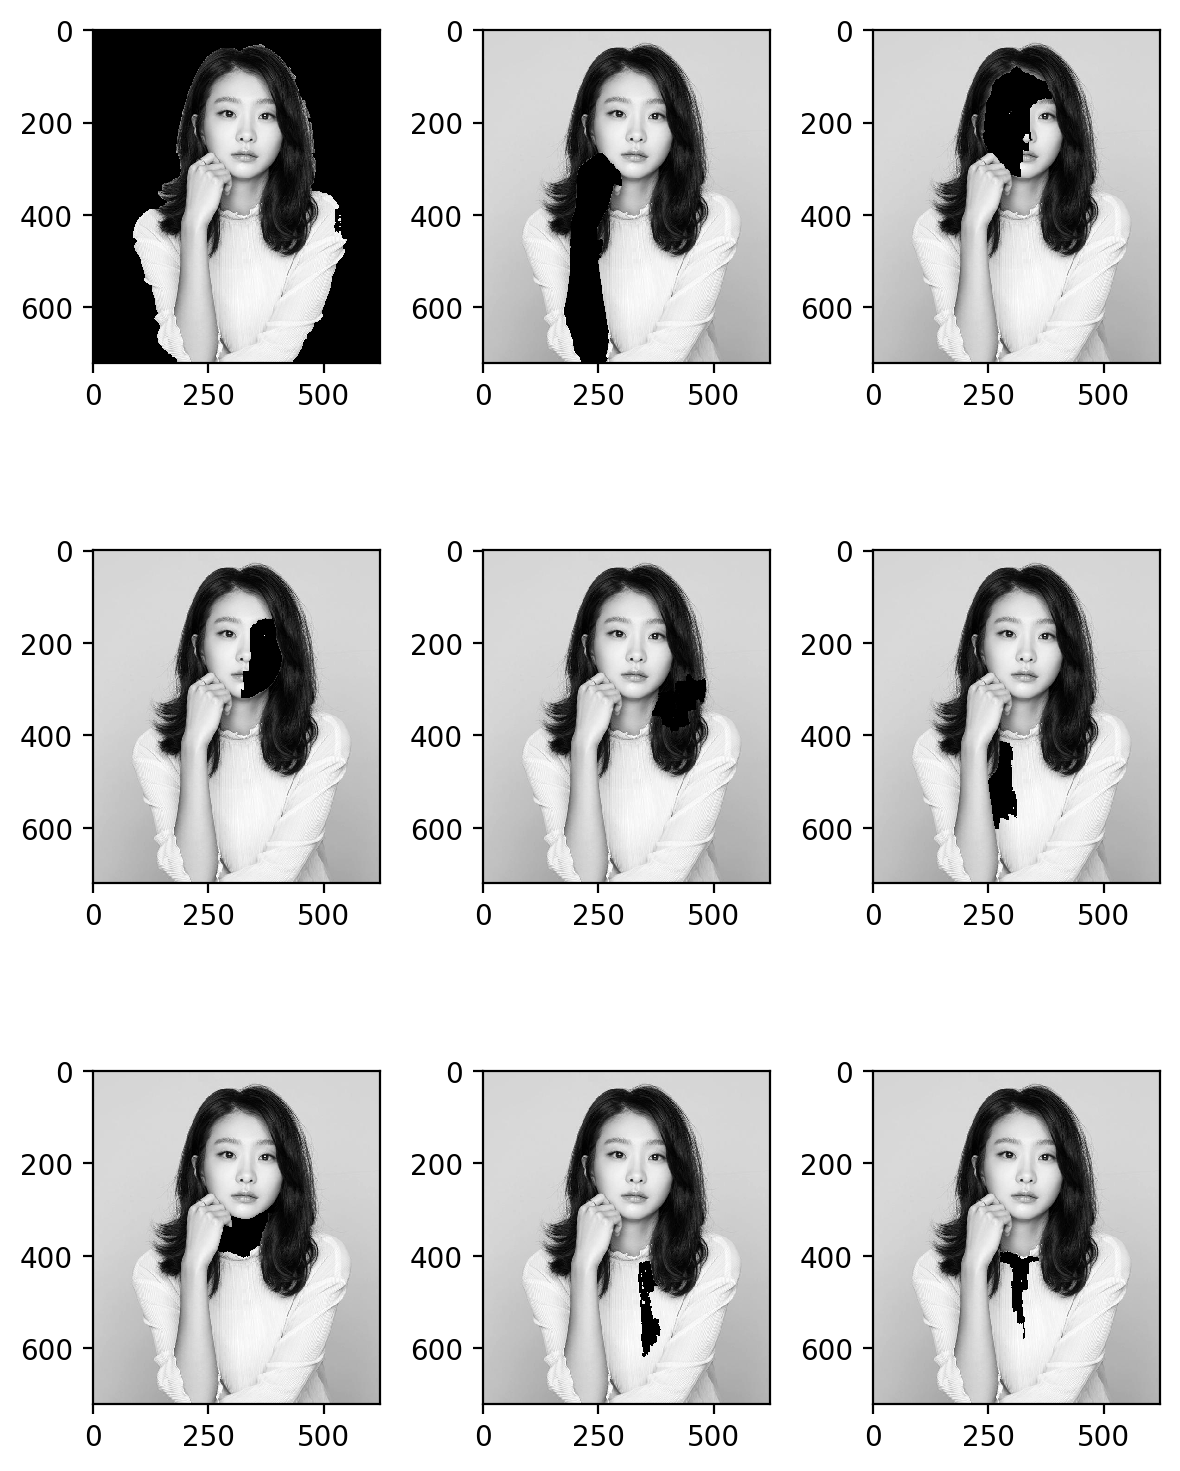

In [27]:
N = 3
fig, axes = plt.subplots(N, N, figsize=(6, 8))
for i in range(N*N):
    draw_group_as_bg(axes.ravel()[i], background_candidates[i], ws, img)
plt.tight_layout()

## Manually inputting seeds

In [28]:
seed_mask = np.zeros(img.shape, dtype=np.int)
seed_mask[0, 0] = 1 # Background
seed_mask[600, 400] = 2 # Foreground

<ipython-input-28-c39b7d46f5e4>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seed_mask = np.zeros(img.shape, dtype=np.int)


C:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


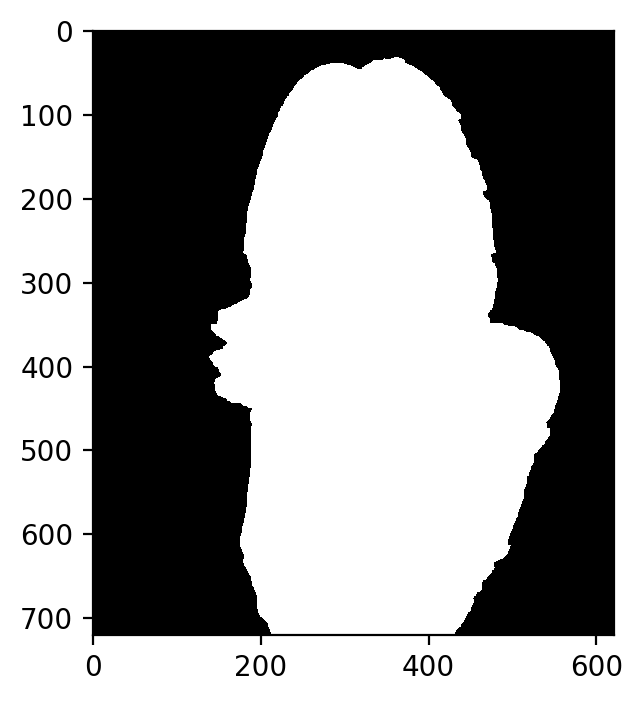

In [29]:
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

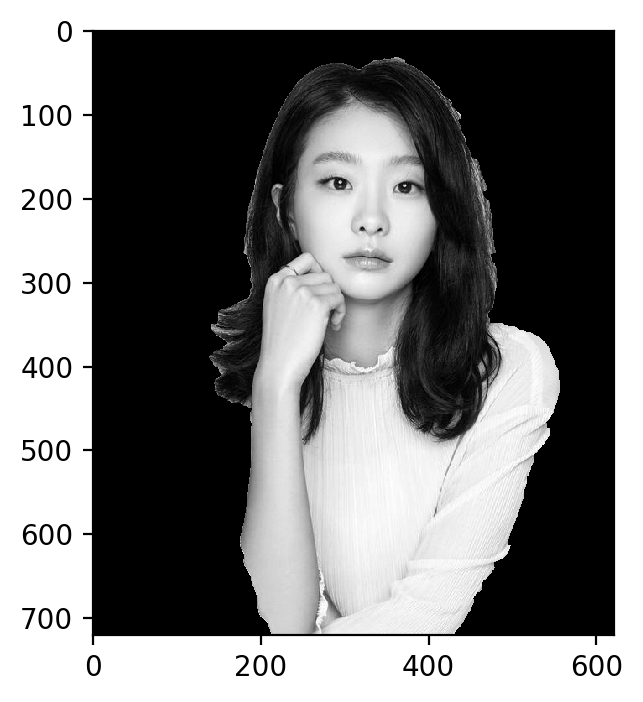

In [30]:
fig, ax = plt.subplots()
draw_group_as_bg(ax, 1, ws, img)

In [31]:
seed_mask = np.zeros(img.shape, dtype=np.int)
seed_mask[0, 0] = 1
seed_mask[600, 400] =2
seed_mask[700, 300]

<ipython-input-31-c3843b616f6f>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seed_mask = np.zeros(img.shape, dtype=np.int)


0

C:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


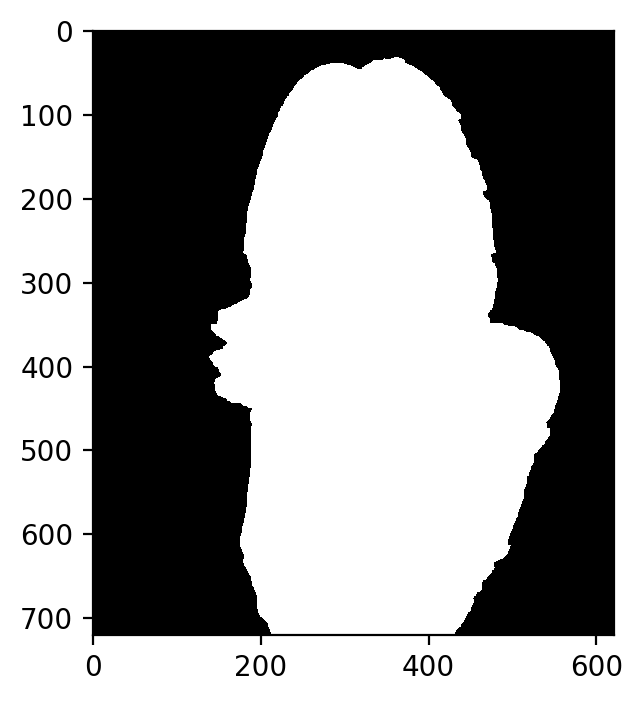

In [32]:
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

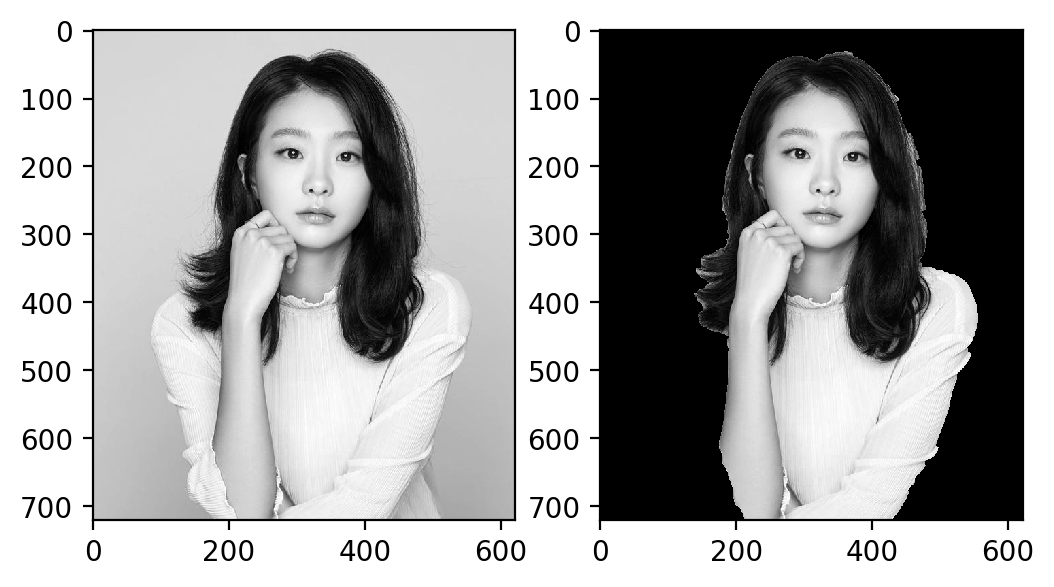

In [33]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
draw_group_as_bg(ax[1], 1, ws, img)